# 1. Building Unit for Neuron Operation

In [ ]:
import math

class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 # Zero means having no effect on final outputc
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # reper allow to print nicer looking object representation
    # When you print object of class following return value of repr function get returned.
    # in this case it's string
    def __repr__(self):
        return f"Value(data={self.data})"

    # When you do add 2 object this class like (a + b), in underneath `a.__add__(b)` this kind of operation get called
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1

        for node in reversed(topo):
            node._backward()

# 2. Visualization Setup

In [3]:
# !pip install graphviz
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        # dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        dot.node(name=uid, label=f"{n.label} | data:{n.data:.4f} | grad:{n.grad:.4f}", shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

# 3. Basic Example

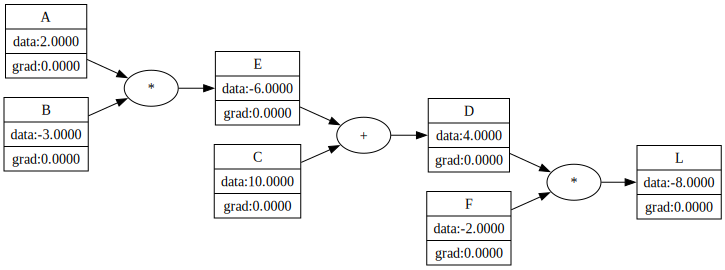

In [4]:
a = Value(2, label="A")
b = Value(-3, label="B")
c = Value(10, label="C")
e = a * b
e.label = "E"
d = e + c
d.label = "D"
f = Value(-2, label="F")
l = d * f
l.label = "L"

draw_dot(l)

# 4. Manual Back Propagation

In [5]:
# Single Neuron

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label='o'

In [6]:
# Manual Backpropagation
o.grad = o.data/o.data
o.grad

1.0

In [7]:
n.grad = 1 - o.data**2 # o = tanh(n); do/dn = 1 - o**2; derivative of tanh is 1 - [tanh(x)]**2
n.grad

0.4999999999999999

In [8]:
x1w1x2w2.grad = n.grad
b.grad = n.grad

In [9]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [10]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

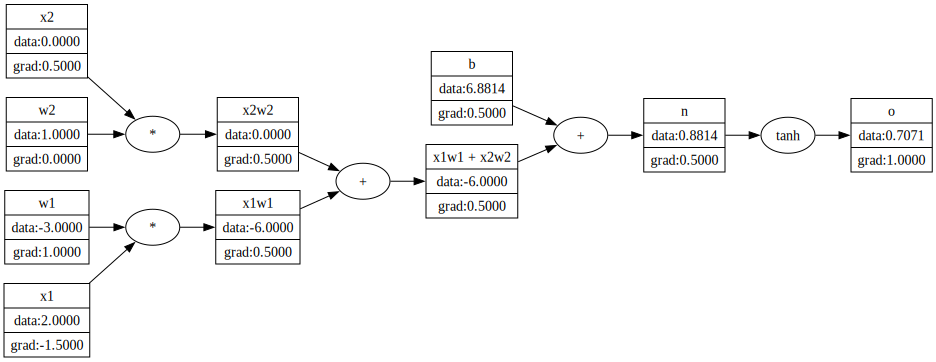

In [11]:
draw_dot(o)

# 5. Back Propagation With Manual Backward Function on each Variable

In [12]:
# Single Neuron

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

In [13]:
o.grad = 1.0

In [14]:
o._backward()

In [15]:
n._backward()

In [16]:
b._backward()

In [17]:
x1w1x2w2._backward()

In [18]:
x2w2._backward()

In [19]:
x1w1._backward()

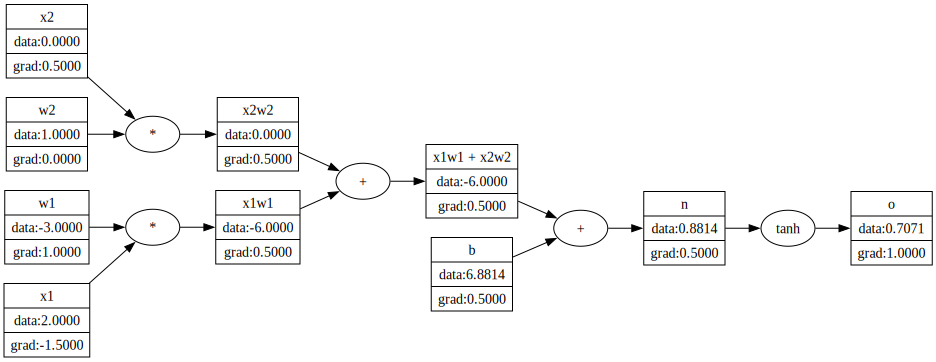

In [20]:
draw_dot(o)

# 6. Automatic Back Propagation with Topological Sort 

In [21]:
# Single Neuron

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

In [22]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
o.grad = 1.0

for node in reversed(topo):
    node._backward()

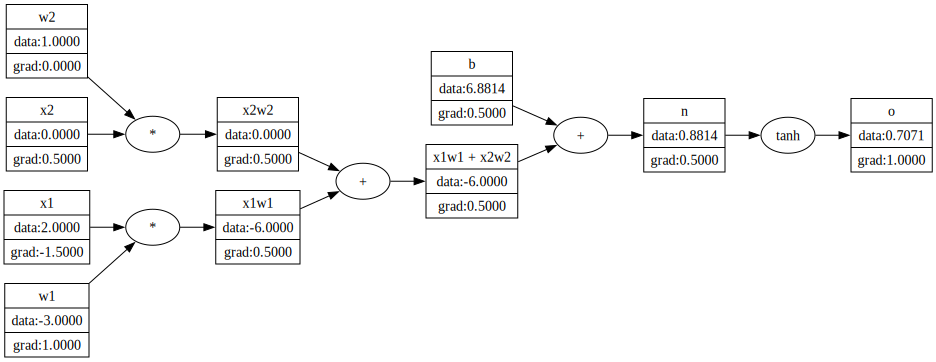

In [23]:
draw_dot(o)

# 7. Moving topological sort function inside Value class

In [24]:
# Single Neuron

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

In [25]:
o.backward()

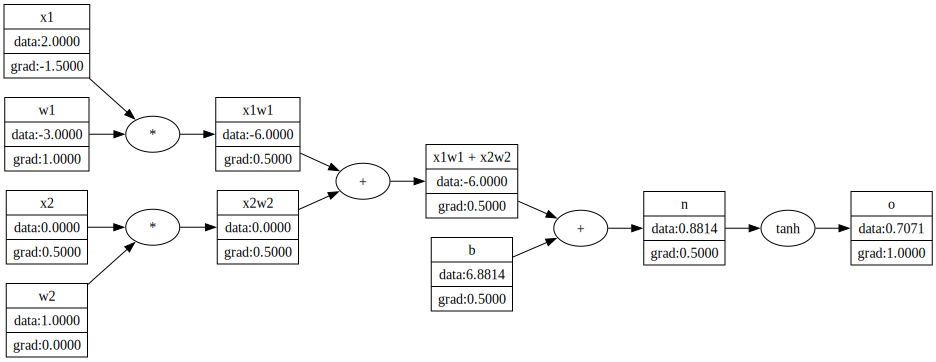

In [26]:
draw_dot(o)

# 8. Fixing a backprop bug when one node is used multiple times

Previously, Used to face issue grad of value used to get overwritten and not accumulate.

![duplicate_value_issue](./images/duplicate_value_issue.JPG)
![duplicate_value_issue_II](./images/duplicate_value_issue_II.JPG)

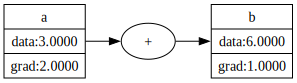

In [27]:
a = Value(3.00, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

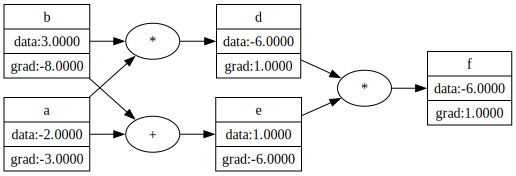

In [28]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)